# Ignition Delay

This Jupyter Notebook was written by Dan Haworth. It was adapted from the Notebook "batch_reactor_ignition_delay_NTC.ipynb" at https://github.com/Cantera/cantera-jupyter/tree/master/reactors. It is intended as a tutorial to be used in parallel with Chapter 6 of the book "An Introduction to Combustion: Concepts and Applications" by Stephen R. Turns and Daniel C. Haworth. That book is referred to as "Turns 4th ed." throughout this Notebook.

This Notebook was last updated 17 February 2020.

The objective of this tutorial is to provide further insight into the autoignition of a homogeneous ideal-gas mixture. The heat-release rate is defined, and negative-temperature-coefficient (NTC) behavior is introduced. Further examples of Pandas DataFrames are shown. We will use the thermodynamic properties and the reaction mechanism that are included in seiser.cti.

The file "seiser.cti" (provided with this Notebook) must be placed in a folder or directory named "data" that is immediately below the folder or directory from which you have opened this Notebook. If you downloaded the .zip file that contains all of the tutorial Notebooks, the appropriate folder and file structure should be in place. The .cti file is also available at https://github.com/Cantera/cantera-jupyter/tree/master/reactors/data.

The reader should be familiar with the material in the Chapter 5 Notebooks before working through this Notebook.

## 1. Motivation and background

As discussed earlier (Chapter 2 of Turns 4th ed., and tutorial Notebook 2_8_Chemical_equilibrium), given sufficient time, an isolated system that is initially not in thermochemical equilibrium (e.g., a fuel-air reactant mixture) will eventually reach a new thermochemical state that corresponds to equilibrium, subject to the constraints imposed (element conservation, and thermodynamic process: e.g., constant-pressure adiabatic, or constant-volume adiabatic). 

For initial conditions (pressure, temperature, and composition) that are representative of fuel-air reactant mixtures in practical combustion applications, the time that is available for combustion is relatively short: much less than 1 s, in most cases. For a homogeneous, isolated fuel-air mixture at such conditions, one typically observes an *induction period* in which the fuel and air start to break down relatively slowly, followed by a rapid (but not instantaneous) change to the final equibrium state (*autoignition*) at a time that is referred to as the *ignition-delay time*. We have seen this behavior in earlier tutorial Notebooks: 4_3_Constant_volume_reactor, 5_2_Global_reactions, and 5_4_A_larger_reaction_mechanism for constant-volume adiabatic systems, and 4_4_Chemical_time_scales for a constant-pressure adiabatic system. 

The ignition-delay time of a reactant mixture is very sensitive to rates at which chemical reactions occur (chemical kinetics). Comparisons between measured and computed ignition-delay times over a range of initial conditions are therefore often used to develop and validate reaction mechanisms.

In our previous tutorials, we have taken the time at which the temperature increases rapidly toward its final (equilibrium) value as the ignition-delay time. There are usually large differences between the final equilibrium states for constant-volume versus constant-pressure adiabatic systems. But in most cases, the differences between the ignition-delay times for constant-volume versus constant-pressure adiabatic systems are small, because the changes in mixture pressure and temperature from their initial values remain small up to the point of ignition.

Ignition-delay time can be defined based on the time evolution of quantities other than temperature: for example, species mass or mole fractions, or *heat-release rate*. The heat-release rate is the rate at which chemical enthalpy (as quantified using species formation enthalpies) is converted to sensible enthalpy (or heat) in a combustion process. In terms of quantities that have been defined earlier in Turns 4th ed. and in previous tutorial Notebooks, the volumetric heat-release rate (denoted here as $ \dot q _ {chem} $, with SI units W/m^3) can be written as the sum over all species in the mixture ($N_{spec}$ species) of the product of the species molar net production rate ($\dot \omega _i$ for species $i$, units of kmol_i/m^3-s: see tutorial Notebook 4_1_Chemical_kinetics_Cantera_basics) times the species molar formation enthalpy ($ \overline h ^ 0 _{f,i} ( T_{ref}) $ for species $i$, units of J/kmol_i: see tutorial Notebook 2_4_Enthalpy), and with a sign change so that $ \dot q _ {chem} >0 $ for an exothermic reaction:
$$
\dot q _ {chem} = - \sum _ {i=1} ^ {N_{spec}} \Bigl( \dot \omega _ i \overline h ^ 0 _{f,i} ( T_{ref}) \Bigr) \ .
$$

## 2. Heat-release rate and ignition delay for a constant-volume adiabatic reactor

Here we consider autoigntion of n-heptane/air mixtures in a constant-volume adiabatic reactor. 

As discussed in tutorial Notebook 4_3_Constant_volume_reactor, the governing equations are developed in Chapter 6 of Turns 4th ed. In Cantera, we do not need to explicitly provide the equations: they are implicitly embedded in Cantera's [`IdealGasReactor()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/zerodim.html#idealgasreactor) object.

We could use the reaction mechanism introduced in tutorial Notebook 5_4_A_larger_reaction_mechanism, but as we saw there, that mechanism requires long computational times. Instead, we will use a somewhat more compact n-heptane mechanism.

In [1]:
# import modules
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# report Cantera version
print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.4.0


In [2]:
# define a gas mixture based on seiser.cti
# the file "seiser.cti" must be present in subdirectory "data" below the current working directory
gas = ct.Solution('data/seiser.cti')



**** WARNING ****
For species c7h15o-1, discontinuity in h/RT detected at Tmid = 1391
	Value computed using low-temperature polynomial:  21.8343
	Value computed using high-temperature polynomial: 21.767


As we have seen before, the warnings pertain to discontinuities in thermodynamic properties at temperature Tmid. Here we will live with the small discontinuities, which will not cause problems for our current purposes.

In [3]:
# print the number of species and the number of reactions in the reaction mechanism
gas.n_species, gas.n_reactions

(160, 1540)

In [4]:
# print the list of species names
gas.species_names

['n2',
 'ch3',
 'h',
 'ch4',
 'h2',
 'oh',
 'h2o',
 'o',
 'c2h6',
 'c2h5',
 'hco',
 'co',
 'co2',
 'o2',
 'h2o2',
 'ho2',
 'c2h4',
 'ch3oh',
 'ch2oh',
 'ch3o',
 'ch2o',
 'c2h2',
 'c2h3',
 'c2h',
 'hcco',
 'ch2',
 'ch',
 'ch2co',
 'ch2(s)',
 'pc2h4oh',
 'ch3co',
 'ch3cho',
 'c3h5-s',
 'c3h4-p',
 'c3h5-a',
 'c3h6',
 'c3h4-a',
 'ch3chco',
 'c3h5-t',
 'c4h6',
 'nc3h7',
 'ic3h7',
 'c3h8',
 'c5h9',
 'c4h7',
 'c4h8-1',
 'sc4h9',
 'pc4h9',
 'ch3coch3',
 'ch3coch2',
 'c2h5co',
 'c2h5cho',
 'c5h10-1',
 'ch2cho',
 'c5h11-1',
 'c5h11-2',
 'c2h5o',
 'c2h5o2',
 'ch3o2',
 'ch3o2h',
 'c3h2',
 'o2c2h4oh',
 'c2h4o2h',
 'c2h3co',
 'c2h3cho',
 'c3h5o',
 'c3h6o1-2',
 'c3h6ooh1-2',
 'c3h6ooh2-1',
 'nc3h7o',
 'ic3h7o',
 'nc3h7o2',
 'ic3h7o2',
 'c4h7o',
 'c4h8ooh1-3o2',
 'c4h8ooh1-3',
 'nc4ket13',
 'c4h8ooh1-2',
 'c4h8o1-3',
 'pc4h9o2',
 'c3h3',
 'hocho',
 'c2h3o1,2',
 'nc3h7cho',
 'nc3h7co',
 'c3h6cho-2',
 'ch2ch2coch3',
 'c2h5coch2',
 'c2h5coc2h4p',
 'nc3h7coch2',
 'nc4h9cho',
 'nc4h9co',
 'hoch2o',
 'c6h13

This mechanism is much smaller than the detailed mechanism used in tutorial Notebook 5_4_A_larger_reaction_mechanism. We anticipate that the computational time required for the current mechanism should be considerably shorter, and that is indeed the case.

Note that the species names are in lower case in this input data file. The primary fuel molecule (n-heptane) is named "nc7h16" here.

To compute the heat-release rate, we will need the species formation enthalpies. So let's go ahead and compute and store those. See tutorial Notebook 2_4_Enthalpy.

In [5]:
# set the mixture to the reference temperature
Tref   = 298.15
gas.TP = Tref , None

# since sensible enthalpies (with respect to Tref) are equal to zero at Tref, 
#   the species standardized enthalpies are equal to the formation enthalpies at Tref
# so "hf" is an array that contains the species formation enthalpies in J/kmol at the reference temperature Tref
hf  = gas.partial_molar_enthalpies

# print the species formation enthalpies
hf

array([ 1.42891877e+03,  1.45699995e+08,  2.17980294e+08, -7.48940729e+07,
        2.44783627e+03,  3.97102396e+07, -2.41846308e+08,  2.49198666e+08,
       -8.53623694e+07,  1.17227354e+08,  4.35174734e+07, -1.10541369e+08,
       -3.93548610e+08, -8.47805650e+02, -1.36108561e+08,  1.59008337e+07,
        5.24647117e+07, -2.01101574e+08, -1.71677262e+07,  1.63037126e+07,
       -1.15915979e+08,  2.26770213e+08,  2.86255220e+08,  5.64904602e+08,
        1.77606017e+08,  3.86994673e+08,  5.94183958e+08, -5.18711406e+07,
        4.24729413e+08, -3.01278947e+07, -2.26024096e+07, -1.65321202e+08,
        2.66757405e+08,  1.91516067e+08,  1.70515518e+08,  1.94575992e+07,
        1.99312049e+08, -8.20566696e+07,  2.57551659e+08,  1.46305385e+08,
        9.45611700e+07,  7.61511955e+07, -1.03855002e+08,  1.19088875e+08,
        1.37584054e+08, -4.60286791e+05,  6.73274772e+07,  7.84162163e+07,
       -2.15749203e+08, -3.03789604e+07, -3.18016665e+07, -1.86207128e+08,
       -2.10895259e+07,  

Next, we define a function that computes the heat-release rate.

In [6]:
# define a function that returns the heat-release rate in W/m^3
# the gas mixture "gas" must be defined on calling this function,
#   and the thermochemical state of "gas" (temperature, pressure, and composition) must be set to the
#   conditions at which the heat-release rate is to be computed
def heat_release_rate():
    qdot = 0.
    for i in range(gas.n_species):
        qdot += -gas.net_production_rates[i]*hf[i]
    return qdot

In [7]:
# specify the initial temperature, pressure, and composition
# a stoichiometric mixture of n-heptane and air is considered first
T_0  = 1000.   # (K)
p_0  = 101325. # (Pa)
fuel = 'nc7h16'
air  = {'o2':1.0, 'n2':3.76}
phi  = 1.0

gas.TP = T_0, p_0
gas.set_equivalence_ratio(phi,fuel,air)

# save the initial mixture composition (species mole fractions)
X_0 = gas.X

In [8]:
# print the full initial state of the mixture
gas()


  gas:

       temperature            1000  K
          pressure          101325  Pa
           density        0.367888  kg/m^3
  mean mol. weight         30.1879  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      7.1647e+05        2.163e+07     J
   internal energy      4.4105e+05        1.331e+07     J
           entropy          8152.1        2.461e+05     J/K
    Gibbs function     -7.4356e+06       -2.245e+08     J
 heat capacity c_p          1316.7        3.975e+04     J/K
 heat capacity c_v          1041.3        3.143e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                n2       0.775112         0.719281         -25.1053
                o2       0.206147         0.218513         -28.1338
            nc7h16      0.0187406        0.0622065         -92.7345
     [ +157 minor]          

We will use `IdealGasReactor()`, as we did earlier in tutorial Notebook 4_3_Constant_volume_reactor.

In addition to the state variables that are associated with the reactor, we will compute and include in our Pandas DataFrame the time evolution of the heat-release rate. For that, we follow the model that was introduced in tutorial Notebook 4_4_Chemical_time_scales.

In [9]:
# define and name a constant-volume reactor that is filled with the ideal-gas mixture "gas"
reactor = ct.IdealGasReactor(contents=gas,name="Constant-volume batch reactor")

# add "reactor" to a reactor network named "reactorNetwork"
reactorNetwork = ct.ReactorNet([reactor])

# create a list of all variables (named "stateVariableNames") for which we will compute and store time-dependent data
# append two more, beyond those that are used internally to characterize the reactor state
stateVariableNames = [reactor.component_name(i) for i in range(reactor.n_vars)]
stateVariableNames.append('qdot')
stateVariableNames.append('empty')

# create a Pandas DataFrame named "timeHistory", using the state variable names as column headings
timeHistory = pd.DataFrame(columns=stateVariableNames)

# define an array to hold the heat-release rate at the current time t
# this is done for convenience in subsequent operations
# only array index 0 will actually be used
qdott = np.zeros(2)

# fill the first row of "timeHistory" with the initial condition
t        = 0.
qdott[0] = heat_release_rate()
timeHistory.loc[t] = np.concatenate((reactor.get_state(),qdott))

timeHistory

,mass,volume,temperature,n2,ch3,h,ch4,h2,oh,h2o,...,nc7ket36,nc7ket42,nc7ket43,nc4h9coch2,c4h7ooh1-4,c5h9ooh1-4,c4h7o1-4,c5h9o1-4,qdot,empty
0.0,0.367888,1.0,1000.0,0.719281,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8673.522136,0.0


Here we will use [`advance()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/zerodim.html#cantera.ReactorNet.advance) rather than [`step()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/zerodim.html#cantera.ReactorNet.step) to perform the time integration.

In [10]:
# let's see what "advance" does
help(reactorNetwork.__class__.advance)

Help on method_descriptor:

advance(...)
    ReactorNet.advance(self, double t)
    
    Advance the state of the reactor network in time from the current
    time to time *t* [s], taking as many integrator timesteps as necessary.



That is, "advance" integrates the system in time from the current time to a specified end time, taking as many internal computational time steps as needed, and ending at exactly the specified end time. 

We also define a function that will return the ignition-delay time, given the time history of the system. At discussed earlier, ignition-delay time can be defined in various ways: for example, as the instant at which the time-rate-of-increase of temperature has its maximum value. Here a simpler definition is used, based on the instant at which a specified species mass fraction or the heat-release rate reaches its maximum value. From our earlier experience with constant-pressure and constant-volume reactors, we expect that a reasonable species choice might be OH. We will confirm that below.

In [11]:
# define a function that returns the time at which a specified quantity in a Pandas DataFrame has its maximum value
# here "df" is a Pandas DataFrame that contains the time evolution of the system, and "quantity" is the quantity name:
#   that is, the name assigned to a particular column of the DataFrame
def ignitionDelay(df, quantity):
# 'idxmax' returns the index (row - here time) in the DataFrame at which the value in column "species" has its max value
    return df[quantity].idxmax()

In [12]:
# specify the integration end time in seconds, and the number of uniform time intervals at which to save the reactor state
# experience and/or trial-and-error are usually needed to estimate an appropriate end-time value
#   that allows the system to reach steady state, without wasting computational effort by computing far beyond
#   the steady state
# alternatively, "advance_to_steady_state" could be used to integrate directly from the current time to the steady state
#   solution, without the need to explicitly specify an end time (although other parameters would be needed)
t_end   = 0.1          # end time for time integration (s)
n_save  = 2000         # number of uniform time intervals at which the solution will be saved
dt_save = t_end/n_save # time interval at which the solution will be saved

# initialize the timer to monitor computer time required
ctim0 = time.time()

# perform the time integration, and save the state at the end of each time interval
# recall that "t" was initialized to zero earlier
while(t < t_end):
    t += dt_save
    reactorNetwork.advance(t)
    qdott[0] = heat_release_rate()
    timeHistory.loc[t] = np.concatenate((reactor.get_state(),qdott))

# the computer time needed to perform the integration is the difference between ctim1 and ctim0
ctim1 = time.time()
ctime = ctim1 - ctim0

# the ignition delay time "tauOH" is the time at which OH mass fraction attains it maximum value
tauOH = ignitionDelay(timeHistory, 'oh')

# the ignition delay time "tauHRR" is the time at which the heat-release rate attains it maximum value
tauHRR = ignitionDelay(timeHistory, 'qdot')

# print the ignition delay times and computer time required
print('Ignition delay based on OH  is {:.3e} seconds.'.format(tauOH))
print('Ignition delay based on HRR is {:.3e} seconds.'.format(tauHRR))
print('This required {:3.2f} s to compute'.format(ctime))

Ignition delay based on OH  is 3.250e-02 seconds.
Ignition delay based on HRR is 3.250e-02 seconds.
This required 14.60 s to compute


For this case, the ignition-delay times based on maximum OH mass fraction and on maximum heat-release rate are equal, to within four significant figures.

In [13]:
# save the time history to an Excel-compatible file for subsequent external post-processing
timeHistory.to_csv("time_history.csv")

Before proceeding, we confirm that the steady-state solution from the time integration is consistent with chemical equilibrium. This should always be the case, provided that we integrated long enough in time to reach equilibrium. In this case, it is the constant-volume adiabatic equilibrium state (constant mixture internal energy and volume) that is relevant.

In [14]:
# print the final mixture state from the time integration
gas()


  gas:

       temperature         2839.29  K
          pressure          316316  Pa
           density        0.367888  kg/m^3
  mean mol. weight         27.4561  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      1.3009e+06        3.572e+07     J
   internal energy      4.4105e+05        1.211e+07     J
           entropy          9844.9        2.703e+05     J/K
    Gibbs function     -2.6652e+07       -7.318e+08     J
 heat capacity c_p          1483.5        4.073e+04     J/K
 heat capacity c_v          1180.7        3.242e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                n2        0.70497         0.719281           -27.38
               ch3    3.94193e-14      2.15858e-14         -55.5187
                 h     0.00509598      0.000187078         -12.0879
                h2      0.01

In [15]:
# reset "gas" to the initial reactant mixture
gas.TPX = T_0, p_0, X_0
gas()


  gas:

       temperature            1000  K
          pressure          101325  Pa
           density        0.367888  kg/m^3
  mean mol. weight         30.1879  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      7.1647e+05        2.163e+07     J
   internal energy      4.4105e+05        1.331e+07     J
           entropy          8152.1        2.461e+05     J/K
    Gibbs function     -7.4356e+06       -2.245e+08     J
 heat capacity c_p          1316.7        3.975e+04     J/K
 heat capacity c_v          1041.3        3.143e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                n2       0.775112         0.719281         -25.1053
                o2       0.206147         0.218513         -28.1338
            nc7h16      0.0187406        0.0622065         -92.7345
     [ +157 minor]          

In [16]:
# compute the equilibrium composition and temperature, for a constant-volume adiabatic process
#   (contant mixture internal energy and volume)
gas.equilibrate('UV')
gas()


  gas:

       temperature         2837.06  K
          pressure          316134  Pa
           density        0.367888  kg/m^3
  mean mol. weight         27.4504  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      1.3004e+06         3.57e+07     J
   internal energy      4.4105e+05        1.211e+07     J
           entropy            9845        2.702e+05     J/K
    Gibbs function      -2.663e+07        -7.31e+08     J
 heat capacity c_p          1483.5        4.072e+04     J/K
 heat capacity c_v          1180.7        3.241e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                n2       0.704822         0.719281         -27.3779
               ch3     5.0237e-14      2.75152e-14         -55.2664
                 h     0.00541933       0.00019899          -12.018
                h2      0.01

The steady-state solution from the time integration agrees with the equilibrium solution, to a good approximation. For example, the steady-state temperature is within approximately 2 K of the equilibrium temperature. Closer agreement presumably could be realized by enforcing tighter numerical tolerances during the time integration for the constant-volume reactor.

Now, let's confirm that maximum OH mass fraction and maximum heat-release rate are reasonable choices for defining the ignition-delay time.

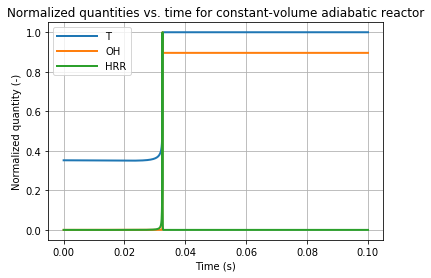

In [17]:
# plot the time evolution of temperature, OH, and heat-release rate
# scale each quantitity by its maximum value, so that it ranges from 0 to 1
Tmax   = max(timeHistory['temperature'])
OHmax  = max(timeHistory['oh'])
HRRmax = max(timeHistory['qdot'])

fig, ax = plt.subplots()
ax.plot(timeHistory.index, timeHistory['temperature']/Tmax, label='T',   lw=2)
ax.plot(timeHistory.index, timeHistory['oh']/OHmax,         label='OH',  lw=2)
ax.plot(timeHistory.index, timeHistory['qdot']/HRRmax,      label='HRR', lw=2)
ax.set(xlabel='Time (s)',
       ylabel='Normalized quantity (-)',
       title ='Normalized quantities vs. time for constant-volume adiabatic reactor')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("T_vs_t_vconst.pdf")

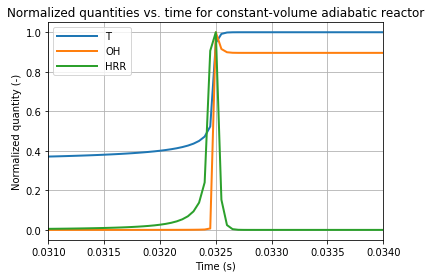

In [18]:
# zoom in around the time of ignition
fig, ax = plt.subplots()
ax.plot(timeHistory.index, timeHistory['temperature']/Tmax, label='T',   lw=2)
ax.plot(timeHistory.index, timeHistory['oh']/OHmax,         label='OH',  lw=2)
ax.plot(timeHistory.index, timeHistory['qdot']/HRRmax,      label='HRR', lw=2)
ax.set(xlim=(0.031,0.034),
       xlabel='Time (s)',
       ylabel='Normalized quantity (-)',
       title ='Normalized quantities vs. time for constant-volume adiabatic reactor')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("T_vs_t_vconst_zoomed.pdf")

The peaks in OH and in heat-release rate occur at very close to the same instant in time, and both coincide to within a good approximation to the instant of maximum time-rate-of-change of temperature. Other good candidate species would be O or H.

The curves could be made smoother by using a larger value of "n_save" above in performing the time integration, at the expense of longer computational time. If too small of a value of "n_save" had been used, the peaks might have been missed altogether. This is an advantage of using `step()` rather than `advance()` to perform the time integration, as the internal computational time step will automatically become smaller around the time of ignition, when the temperature and composition are changing rapidly. 

## 3. Ignition delay versus reactant temperature: NTC behavior

We next consider the constant-volume adiabatic combustion of a stoichiometric n-heptane/air mixture, initially at 1 atm, and over a range of values for the initial temperature.

Here we will go back to `step()` to perform the time integration.

In [19]:
# specify the initial pressure
p_0 = 101325.

# specify the initial mixture composition
fuel = 'nc7h16'
air  = {'o2':1.0, 'n2':3.76}
phi  = 1.0

# specify the initial temperatures for which we will compute the ignition delays
# the reason for the non-uniform temperature intervals will become apparent when we plot the results, below
T_0 = [1800., 1600., 1400., 1200., 1000., 950., 925., 900., 850., 825., 800.,
        750., 700., 675., 650., 625., 600., 550., 500.]

# specify the time integration end time for each initial temperature
# we need to integrate long enough in time that the ignition event is captured
# we expect that the ignition delay time should decrease with increasing initial mixture temperature
#   (it is not quite as simple as that, as we will see . . .)
# we start by specifying an end time of 1.0 s for each temperature
EndTimes = np.ones(len(T_0))

# we then decrease the end times for the higher temperatures, and increase the end times for the lower temperatures
# a combination of experience and trial-and-error is needed to find optimum values, for which ignition is achieved
#   in each case, without wasting computational effort by computing long beyond the ignition delay time
# in fact, the internal computational time step becomes quite large as the system approaches its post-ignition steady state,
#   so there is relatively little penalty in computer time for computing beyond the time of ignition

# decrease the end times to 0.1 s for the six highest initial temperatures
EndTimes[:6] = 6*[0.1]
# increase the end time to 10. s for the next-to-lowest initial temperature
EndTimes[-2:] = 10.
# increase the end time to 100. s for the lowest initial temperature
EndTimes[-1] = 100.

# print the integration end time for each initial temperature
for i in range (len(T_0)):
    print(i, T_0[i], EndTimes[i])

0 1800.0 0.1
1 1600.0 0.1
2 1400.0 0.1
3 1200.0 0.1
4 1000.0 0.1
5 950.0 0.1
6 925.0 1.0
7 900.0 1.0
8 850.0 1.0
9 825.0 1.0
10 800.0 1.0
11 750.0 1.0
12 700.0 1.0
13 675.0 1.0
14 650.0 1.0
15 625.0 1.0
16 600.0 1.0
17 550.0 10.0
18 500.0 100.0


In [20]:
# create another DataFrame to store the computed ignition delays for each initial temperature
ignitionDelays = pd.DataFrame(data={'T':T_0})
# initialize all ignition delay values to an undefined value ("nan" = not a number)
ignitionDelays['ignDelay'] = np.nan

# print the initialized DataFrame
ignitionDelays

,T,ignDelay
0,1800.0,NaN
1,1600.0,NaN
2,1400.0,NaN
3,1200.0,NaN
4,1000.0,NaN
5,950.0,NaN
6,925.0,NaN
7,900.0,NaN
8,850.0,NaN
9,825.0,NaN


Now compute the ignition delay for each initial temperature. To make this more self-contained, we repeat the definition of "gas" and the definitions of the functions that compute the heat-release rate and ignition-delay time.

Be patient when you run this cell. The calculation for each value of the initial temperature may take several seconds, depending on your computer.

In [21]:
# define the gas mixture
gas = ct.Solution('data/seiser.cti')

# compute species formation enthalpies
Tref   = 298.15
gas.TP = Tref , None
hf     = gas.partial_molar_enthalpies

# define a function that returns the time at which a specified quantity in a DataFrame reaches its maximum value
def ignitionDelay(df, quantity):
    return df[quantity].idxmax()

# define a function that returns the heat-release rate in W/m^3
def heat_release_rate():
    qdot = 0.
    for i in range(gas.n_species):
        qdot += -gas.net_production_rates[i]*hf[i]
    return qdot

##### top of loop over initial temperatures #####
for i, temp in enumerate(T_0):
    
# initialize the gas thermochemical state and the reactor network
    gas.TP = temp, p_0
    gas.set_equivalence_ratio(phi,fuel,air)
    reactor = ct.IdealGasReactor(contents=gas, name='Constant-volume batch reactor')
    reactorNetwork = ct.ReactorNet([reactor])

# create an empty data frame to store the time history for the current initial temperature
    timeHistory = pd.DataFrame(columns=timeHistory.columns)
    
# store the initial condition
    t = 0.
    qdott[0] = heat_release_rate()
    timeHistory.loc[t] = np.concatenate((reactor.get_state(),qdott))

# initialize the timer
    ctim0 = time.time()

# perform the time integration for the current initial temperature
# save the reactor state once every 10 computational time steps
    counter = 0
    while t < EndTimes[i]:
        t = reactorNetwork.step()
        if not counter % 10:
            qdott[0] = heat_release_rate()
            timeHistory.loc[t] = np.concatenate((reactor.get_state(),qdott))
        counter += 1

# compute the elapsed computer time for the current initial temperature
    ctim1 = time.time()
    ctime = ctim1 - ctim0
    
# compute the ignition delay time based on heat-release rate for the current initial temperature
    tau = ignitionDelay(timeHistory, 'qdot')

# print the initial temperature, ignition delay time, and compute time required for the current initial temperature
    print('Initial T = {:3.2f} K, ignition delay (HRR) = {:.3e} s, compute time = {:.3e} s'.format(temp, tau, ctime))

# store the computed ignition delays in a DataFrame
    ignitionDelays.at[i,'ignDelay'] = tau
    
##### end of loop over initial temperatures #####
    
# print the computed ignition delay times
ignitionDelays



**** WARNING ****
For species c7h15o-1, discontinuity in h/RT detected at Tmid = 1391
	Value computed using low-temperature polynomial:  21.8343
	Value computed using high-temperature polynomial: 21.767
Initial T = 1800.00 K, ignition delay (HRR) = 7.178e-06 s, compute time = 2.842e+00 s
Initial T = 1600.00 K, ignition delay (HRR) = 2.501e-05 s, compute time = 2.780e+00 s
Initial T = 1400.00 K, ignition delay (HRR) = 1.514e-04 s, compute time = 2.970e+00 s
Initial T = 1200.00 K, ignition delay (HRR) = 1.620e-03 s, compute time = 3.380e+00 s
Initial T = 1000.00 K, ignition delay (HRR) = 3.247e-02 s, compute time = 3.564e+00 s
Initial T = 950.00 K, ignition delay (HRR) = 7.908e-02 s, compute time = 3.631e+00 s
Initial T = 925.00 K, ignition delay (HRR) = 1.252e-01 s, compute time = 3.865e+00 s
Initial T = 900.00 K, ignition delay (HRR) = 1.983e-01 s, compute time = 4.031e+00 s
Initial T = 850.00 K, ignition delay (HRR) = 4.266e-01 s, compute time = 4.186e+00 s
Initial T = 825.00 K, ign

,T,ignDelay
0,1800.0,0.000007
1,1600.0,0.000025
2,1400.0,0.000151
3,1200.0,0.001620
4,1000.0,0.032470
5,950.0,0.079079
6,925.0,0.125227
7,900.0,0.198336
8,850.0,0.426636
9,825.0,0.472590


Note that the computational time increases with decreasing initial temperature.

Now plot the computed ignition delay time as a function of initial temperature. More specifically, the x axis is taken to be linear in the inverse of the temperature, and a logarithmic scale is used for ignition-delay time on the y axis. This is the conventional way in which the temperature variation of ignition-delay time is often plotted. 

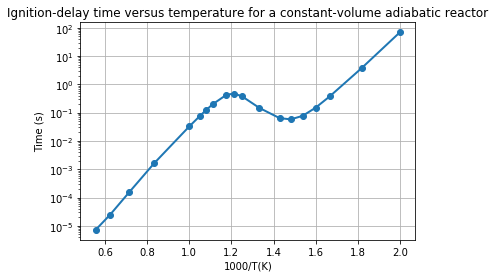

In [22]:
# plot ignition delay versus initial temperature
fig, ax = plt.subplots()
ax.semilogy(1000./ignitionDelays['T'], ignitionDelays['ignDelay'], lw=2, marker='o')
ax.set(xlabel='1000/T(K)',
       ylabel='Time (s)',
       title ='Ignition-delay time versus temperature for a constant-volume adiabatic reactor')
#ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("igndelay_vs_T_vconst.pdf")

From this, it can be seen that the nonuniform temperature intervals were chosen to resolve the nonmonotonic behavior of the ignition-delay time as a function of temperature.

Intuitively, one might expect that the ignition-delay time should be a monotonically increasing function of 1/T. That is, in fact, the case for many fuels burning with air, over at least some ranges of initial pressures, temperatures, and equivalence ratios. However, for some fuels (including n-heptane), there is a range of temperatures over which the ignition delay decreases as the temperature decreases (that is, as 1/T increases). This is called *negative temperature coefficient* (NTC) behavior. NTC behavior is important in some advanced compression-ignition engine combustion systems. This behavior can be difficult to capture in a reaction mechanism, and the ability to accurately capture ignition-delay times in the NTC region is often used as a test or validation case for reaction mechanisms that are to be used to predict autoignition in such systems.

## 4. Two-stage heat release

Another phenomonon that can be seen for some fuels under some conditions is two-stage heat release, where there are two local peaks in the heat-release-rate-versus-time curve: an earlier lower peak (corresponding to low-temperature heat release) and a later higher peak that corresponds to the main ignition event (high-temperature heat release). The reasons for this behavior are beyond our introductory discussion of combustion. This is another phenomenon that is extremely sensitive to the details of the chemical kinetics. 

Two-stage heat release can be observed for the present chemical mechanism for sufficiently low initial reactant temperatures. For example:

In [23]:
# initialize the gas mixture to a relatively low temperature
T_0  = 750.
p_0  = ct.one_atm
fuel = 'nc7h16'
air  = {'o2':1.0, 'n2':3.76}
phi  = 1.0

gas.TP = T_0, p_0
gas.set_equivalence_ratio(phi,fuel,air)

# initialize the reactor, reacto network, and Pandas DataFrame
reactor            = ct.IdealGasReactor(contents=gas, name='Constant-volume batch reactor')
reactorNetwork     = ct.ReactorNet([reactor])
stateVariableNames = [reactor.component_name(i) for i in range(reactor.n_vars)]
stateVariableNames.append('qdot')
stateVariableNames.append('empty')
timeHistory       = pd.DataFrame(columns=stateVariableNames)

qdott    = np.zeros(2)
t        = 0.
qdott[0] = heat_release_rate()
timeHistory.loc[t] = np.concatenate((reactor.get_state(),qdott))

# perform the time integration
ctim0 = time.time()
t_end   = 1.0
counter = 0
while t <= t_end:
    t = reactorNetwork.step()
    if not counter % 10:
        qdott[0]           = heat_release_rate()
        timeHistory.loc[t] = np.concatenate((reactor.get_state(),qdott))
    counter += 1

ctim1 = time.time()
ctime = ctim1 - ctim0
    
# compute the ignition-delay time
tau = ignitionDelay(timeHistory, 'qdot')

print('Initial T = {:3.2f} K, ignition delay (HRR) = {:.3e} s, compute time = {:.3e} s'.format(T_0, tau, ctime))

Initial T = 750.00 K, ignition delay (HRR) = 1.462e-01 s, compute time = 4.890e+00 s


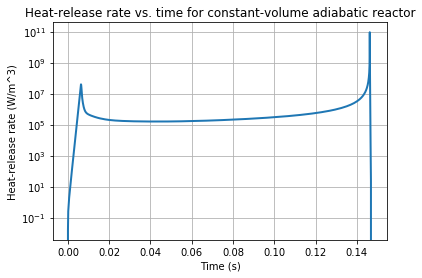

In [24]:
# plot the heat-release rate as a function of time, using a logarithmic scale for the heat-release rate
#   so that the two-peak structure is evident
fig, ax = plt.subplots()
ax.semilogy(timeHistory.index, timeHistory['qdot'], label='HRR', lw=2)
#ax.plot(timeHistory.index, timeHistory['qdot'], label='HRR', lw=2)
ax.set(xlabel='Time (s)',
       ylabel='Heat-release rate (W/m^3)',
       title ='Heat-release rate vs. time for constant-volume adiabatic reactor')
#ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("HRR_vs_t_vconst.pdf")

You can vary the initial conditions to explore the ranges of temperatures, pressures, and equivalence ratios over which two-stage ignition is observed.